In [1]:
import cvxpy as cp
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from utils import *
from MySolution_13 import MyLabelSelection, MyClassifier

%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import display, HTML

display(HTML("<style>.output_wrapper, .output {height:auto !important; max-height:1000px;}</style>"))


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [5]:
from IPython.display import display, HTML

display(HTML("""
    <style>
        .output_scroll {
            height: auto !important;
            max-height: none !important;
        }
    </style>
"""))


Synthetic data shape:  (1000, 2) (1000,)


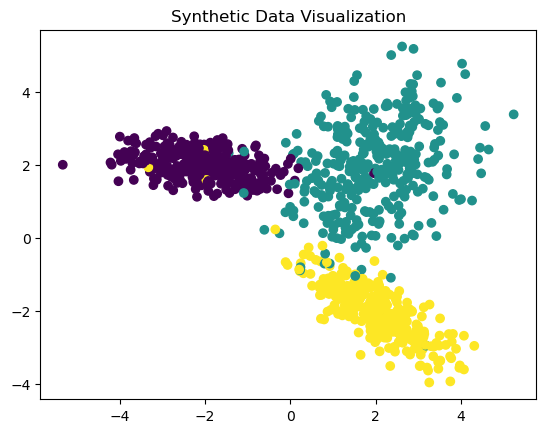

MNIST data shape:  (1000, 784) (1000,)


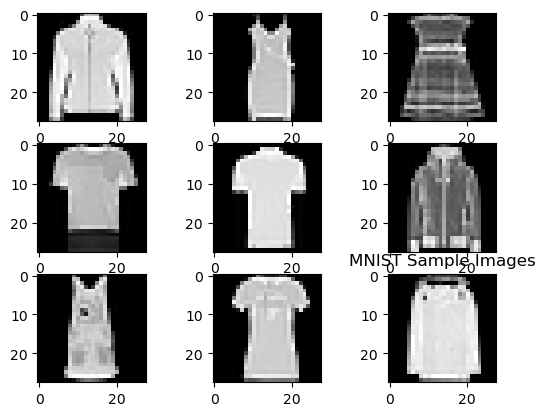

In [6]:
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])
plt.title('Synthetic Data Visualization')
plt.show()

mnist_data = prepare_mnist_data()
print("MNIST data shape: ", mnist_data['trainX'].shape, mnist_data['trainY'].shape)

for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.title('MNIST Sample Images')
plt.show()


In [7]:
def plot_selected_samples(trainX, trainY, selected_indices_algo, selected_indices_random, epsilon, ratio, w, dataset_name='Synthetic Data'):
    plt.figure(figsize=(8, 6))
    plt.scatter(trainX[:, 0], trainX[:, 1], c=trainY, cmap='viridis', alpha=0.6, label='Data Points')
    # MyLabelSelection
    plt.scatter(trainX[selected_indices_algo, 0], trainX[selected_indices_algo, 1],
                c='red', marker='o', edgecolors='k', s=100, label='Selected (MyLabelSelection)')
    # Uniform random
    plt.scatter(trainX[selected_indices_random, 0], trainX[selected_indices_random, 1],
                c='blue', marker='x', s=100, label='Selected (Random)')
    ax = plt.gca()
    for idx in selected_indices_algo:
        circle = patches.Circle((trainX[idx, 0], trainX[idx, 1]), radius=epsilon, linewidth=1.5, edgecolor='red', facecolor='none', linestyle='--')
        ax.add_patch(circle)

        plt.annotate(f'{w[idx]}', (trainX[idx, 0], trainX[idx, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='black', bbox=dict(boxstyle="round", fc="white", ec="black"))
        
    for idx in selected_indices_random:
        pass
        #circle = patches.Circle((trainX[idx, 0], trainX[idx, 1]), epsilon, linewidth=1.5, edgecolor='blue', facecolor='none', linestyle='--')
        #ax.add_patch(circle)
        # plt.annotate(f'{w[idx]}', (trainX[idx, 0], trainX[idx, 1]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='black', bbox=dict(boxstyle="round", fc="white", ec="black"))

    plt.legend()
    plt.title(f'Ratio: {ratio}, {dataset_name}')
    plt.grid(True)
    plt.show()

def plot_diff(results, dataset_name):
    plt.figure(figsize=(8, 6))
    percentages = np.array(results['label_percentage']) * 100
    plt.plot(percentages, np.array(results['test_accuracy(our algo)']) * 100, label='Our Algorithm', marker='o')
    plt.plot(percentages, np.array(results['test_accuracy(random)']) * 100, label='Random Selection', marker='s')
    plt.xlabel('Percentage of Labeled Data (%)')
    plt.ylabel('Test Accuracy (%)')
    plt.title(f'Label Selection Performance on {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def evaluate_label_selection(data, label_percentages, dataset_name):
    test_accuracies_algo = []
    test_accuracies_random = []
    
    trainX = data['trainX']
    trainY = data['trainY']
    testX = data['testX']
    testY = data['testY']
    
    K = len(np.unique(trainY))
    # print(K)

    for ratio in label_percentages:
        # print(f"\nEvaluating for label percentage: {ratio * 100}%")
        n_samples = trainX.shape[0]
        n_labels = int(np.ceil(ratio * n_samples))
        # print(n_labels)
        
        label_selector = MyLabelSelection(ratio=ratio)
        selected_indices = label_selector.select(trainX)
        epsilon = label_selector.epsilon
        w = label_selector.w
        selected_indices = selected_indices.astype(int)
        selected_trainX = trainX[selected_indices]
        selected_trainY = trainY[selected_indices]
        
        classifier = MyClassifier(K)
        # print("Shape of selected_trainX: ", selected_trainX.shape)
        # print("Shape of selected_trainY: ", selected_trainY.shape)
        classifier.train(selected_trainX, selected_trainY)
        
        
        # print(f"Our Algorithm Accuracy: {accuracy_algo * 100:.2f}%")
        
        np.random.seed(42)
        random_indices = np.random.choice(n_samples, n_labels, replace=False)
        random_trainX = trainX[random_indices]
        random_trainY = trainY[random_indices]
        
        classifier_random = MyClassifier(K)
        classifier_random.train(random_trainX, random_trainY)
        
        # Evaluate on test set
        accuracy_random = classifier_random.evaluate(testX, testY)
        test_accuracies_random.append(accuracy_random)
        accuracy_algo = classifier.evaluate(testX, testY)
        test_accuracies_algo.append(accuracy_algo)
        # print(f"Random Selection Accuracy: {accuracy_random * 100:.2f}%")

        # only works for synthetic data
        if dataset_name == "Synthetic":
            plot_selected_samples(trainX, trainY, selected_indices, random_indices, epsilon, ratio, w)
    
    return {
        'label_percentage': label_percentages,
        'test_accuracy(our algo)': test_accuracies_algo,
        'test_accuracy(random)': test_accuracies_random
    }

In [9]:
%matplotlib inline

Epsilon: 0.5488150091742554
Low-density filter applied. 0 points excluded.
Optimal value from label selection:1000.0000000112284


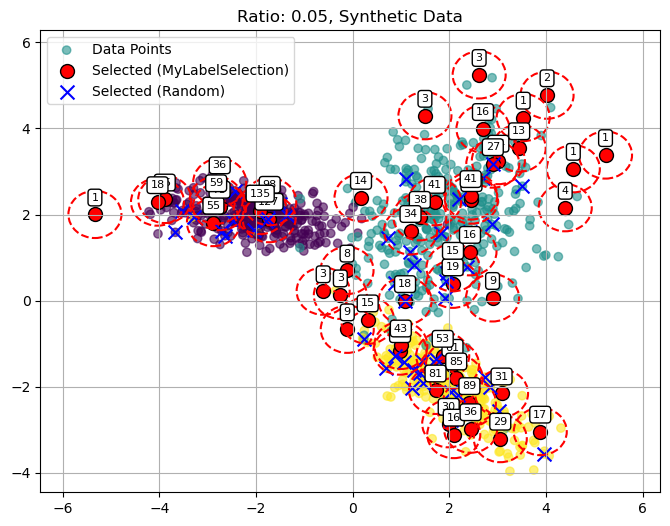

Epsilon: 0.5488150091742554
Low-density filter applied. 847 points excluded.
Optimal value from label selection:1000.0000001883583


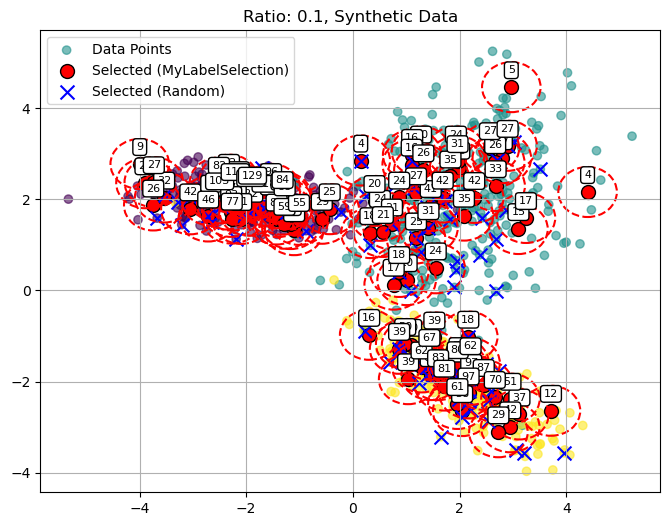

Epsilon: 0.5488150091742554
Low-density filter applied. 778 points excluded.
Optimal value from label selection:1000.0000001158456


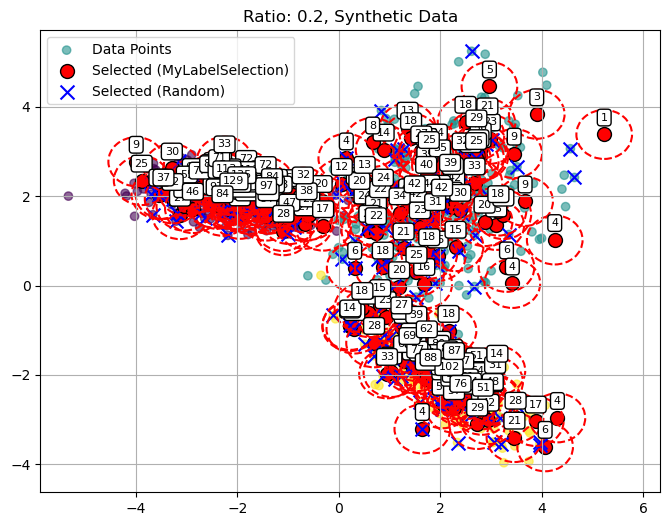

Epsilon: 0.5488150091742554
Low-density filter applied. 722 points excluded.
Optimal value from label selection:1000.0000000717054


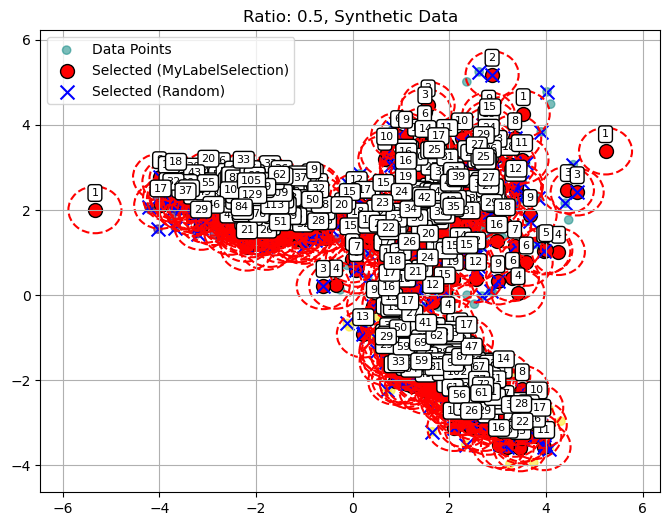

Epsilon: 0.5488150091742554
Low-density filter applied. 0 points excluded.
Optimal value from label selection:1000.0000000494852


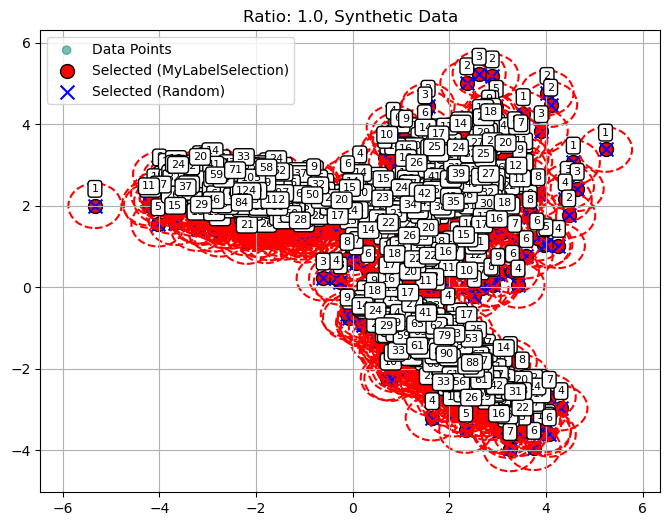

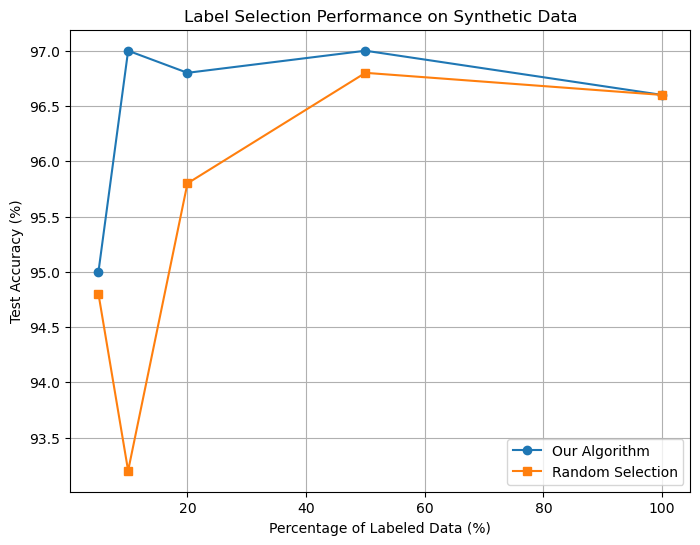

In [10]:
label_percentages = [0.05, 0.1, 0.2, 0.5, 1.0]

result_synthetic = evaluate_label_selection(syn_data, label_percentages, dataset_name="Synthetic")
plot_diff(result_synthetic, 'Synthetic Data')

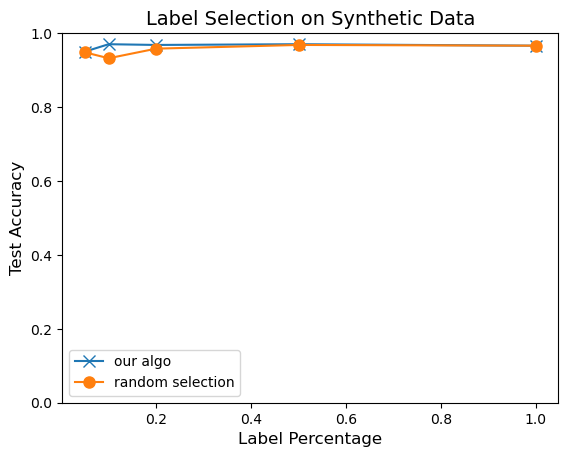

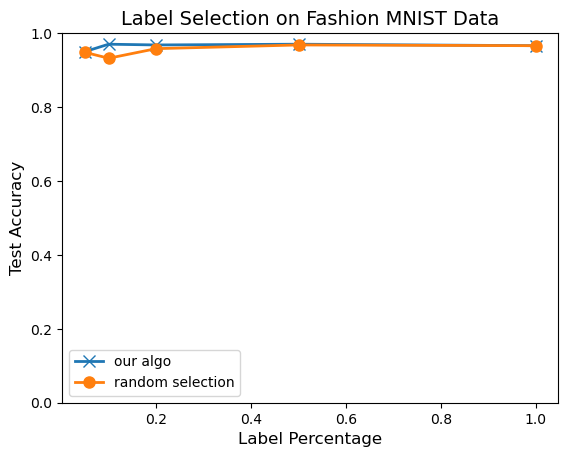

In [11]:
syn_result_plot = {'synthetic': result_synthetic, 'mnist': result_synthetic}
plot_result(result3_1=syn_result_plot)

Epsilon: 1720.3884445084063
Low-density filter applied. 0 points excluded.
Optimal value from label selection:985.6666666580122


/opt/miniconda3/envs/236a/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Epsilon: 1720.3884445084063
Low-density filter applied. 0 points excluded.
Optimal value from label selection:999.9999999996672


/opt/miniconda3/envs/236a/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Epsilon: 1720.3884445084063
Low-density filter applied. 0 points excluded.
Optimal value from label selection:999.9999999995609


/opt/miniconda3/envs/236a/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Epsilon: 1720.3884445084063
Low-density filter applied. 0 points excluded.
Optimal value from label selection:999.9999998290076


/opt/miniconda3/envs/236a/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Epsilon: 1720.3884445084063
Low-density filter applied. 0 points excluded.
Optimal value from label selection:999.9999955415476


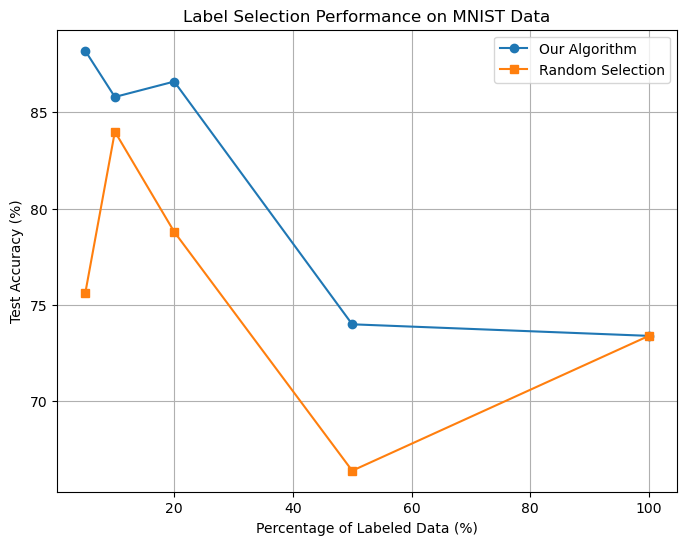

In [12]:
label_percentages = [0.05, 0.1, 0.2, 0.5, 1.0]

result_mnist = evaluate_label_selection(mnist_data, label_percentages, dataset_name="MNIST")
plot_diff(result_mnist, 'MNIST Data')

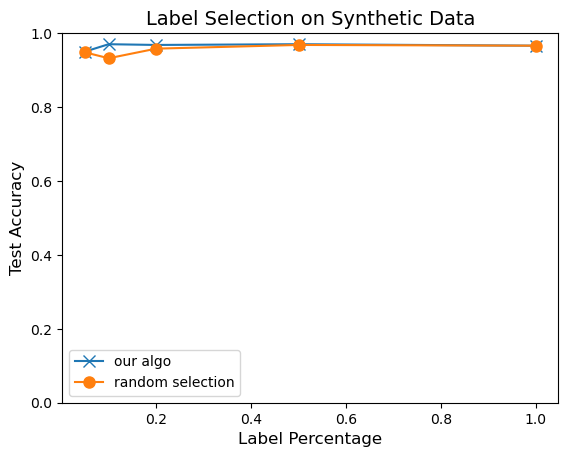

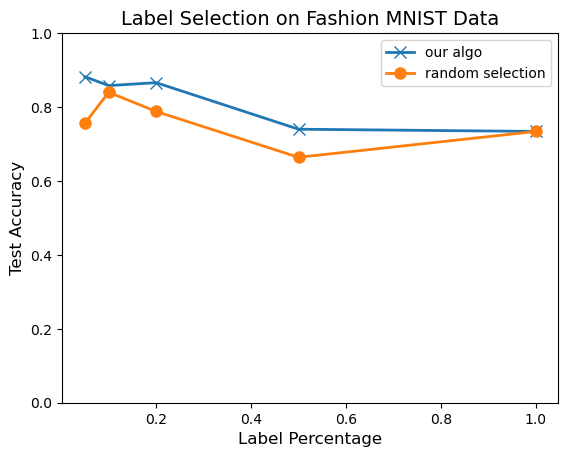

In [13]:
syn_result_plot = {'synthetic': result_synthetic, 'mnist': result_mnist}
plot_result(result3_1=syn_result_plot)